# Lab 4 – Learning on LOBs (Limit Order Books)

## 1. Predictive power of imbalance on future price movements

Choose one of the 10 assets and use the full database (year 2011).

Compute the signed imbalance on your dataset:

$$Imb = \frac{Q_{ask}-Q_{bid}}{Q_{ask}+Q_{bid}}$$

For various horizons $h$ (between 1 and 10 for example), compute the difference between the current price and the future price at horizon $h$, expressed in basis points (bps).

$$diff(h)=100\times100\times\frac{P_{t+h}-P_t}{P_t}$$

Deduce the predictive power of the imbalance on $diff(h)$ as a function of the different values of $h$ (regression). You may round the imbalance to $10^{-1}$ and group (`groupby`) the price movements for a given horizon $h$ according to the value of the imbalance.

Study the relationship for the different horizons $h$ considered. Comment on your results.

In [472]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress

In [473]:
os.listdir()

['.DS_Store', 'TP 4 - Learning on LOBs.ipynb', 'Data']

In [474]:
stk = 'google'

In [475]:
data_folder = "Data"
files = os.listdir(data_folder)
DATAS = {}

for f in files:
    if f.endswith('.h5'):
        key = f.replace(".h5", "").strip().lower()
        DATAS[key] = pd.read_hdf(f'Data/{f}')

DATAS[stk].head()

,TradedPrice,TradedQty,BidPrice,AskPrice,BidQty,AskQty,TradedSign
Time,,,,,,,
2011-01-03 09:30:01.846,597.29,181,597.29,597.39,100,100,-1
2011-01-03 09:30:01.862,597.39,100,596.23,597.49,100,100,0
2011-01-03 09:30:02.492,597.19,100,596.78,597.49,100,100,0
2011-01-03 09:30:02.718,597.19,100,596.78,597.49,100,100,0
2011-01-03 09:30:03.274,597.19,100,596.78,597.49,100,1400,0


In [476]:
DATAS[stk]["Imbalance"] = (DATAS[stk].AskQty - DATAS[stk].BidQty)/(DATAS[stk].AskQty + DATAS[stk].BidQty)

In [477]:
DATAS[stk]["Spread"] = abs(DATAS[stk].BidPrice - DATAS[stk].AskPrice)

In [478]:
DATAS[stk]["Volume"] = DATAS[stk].TradedQty / DATAS[stk].TradedQty.sum()

In [479]:
DATAS[stk].columns

Index(['TradedPrice', 'TradedQty', 'BidPrice', 'AskPrice', 'BidQty', 'AskQty',
       'TradedSign', 'Imbalance', 'Spread', 'Volume'],
      dtype='object')

In [480]:
df = DATAS[stk].copy()

horizons = range(1, 11)
price = df['TradedPrice']

diff = {}
for h in horizons:
    diff[h] = 100 * 100 * (price.shift(-h) - price) / price

diff_df = pd.DataFrame(diff, columns=horizons)
diff_df.index = df.index

In [481]:
diff_df.columns

RangeIndex(start=1, stop=11, step=1)

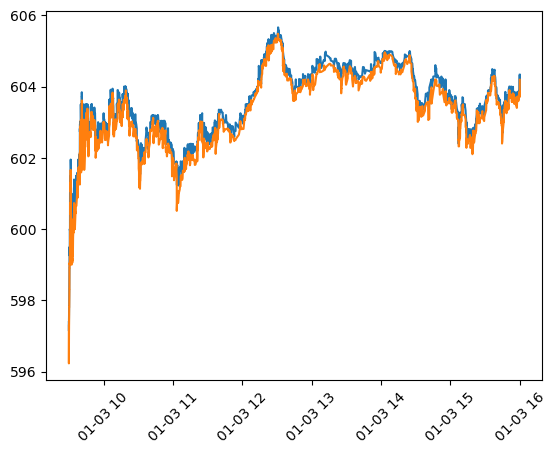

In [482]:
plt.plot(df.AskPrice[:"2011-01-03"])
plt.plot(df.BidPrice[:"2011-01-03"])
plt.xticks(rotation=45)
plt.show()

In [483]:
imbalance = df['Imbalance'].round(1)

In [484]:
results = []
for h in horizons:
    y = diff_df[h]
    mask = y.notna() & imbalance.notna()
    X = imbalance[mask].values.reshape(-1, 1)
    Y = y[mask].values
    reg = LinearRegression().fit(X, Y)
    r2  = reg.score(X, Y)
    results.append({'h': h, 'slope': reg.coef_[0], 'intercept': reg.intercept_, 'R2': r2})

results_df = pd.DataFrame(results).set_index('h')
print(results_df.round(4))

     slope  intercept      R2
h                            
1  -0.1537     0.0010  0.0006
2  -0.2703     0.0019  0.0010
3  -0.3360     0.0028  0.0010
4  -0.3632     0.0036  0.0009
5  -0.3708     0.0043  0.0008
6  -0.3661     0.0051  0.0006
7  -0.3546     0.0059  0.0005
8  -0.3358     0.0066  0.0004
9  -0.3168     0.0074  0.0003
10 -0.3018     0.0081  0.0003


In [485]:
combined = diff_df.copy()
combined['Imbalance_r'] = imbalance.values

grouped = combined.groupby('Imbalance_r')[list(horizons)].mean()

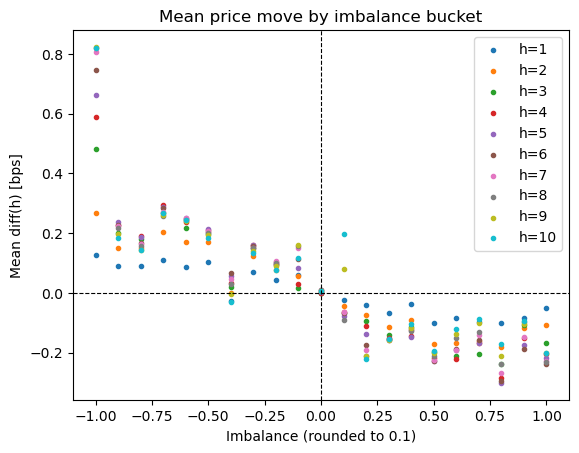

In [486]:
for h in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    plt.scatter(grouped.index, grouped[h], marker='.', label=f'h={h}')
plt.axhline(0, color='k', lw=0.8, ls='--')
plt.axvline(0, color='k', lw=0.8, ls='--')
plt.xlabel('Imbalance (rounded to 0.1)')
plt.ylabel('Mean diff(h) [bps]')
plt.title('Mean price move by imbalance bucket')
plt.legend()

plt.show()

In [487]:
df.columns

Index(['TradedPrice', 'TradedQty', 'BidPrice', 'AskPrice', 'BidQty', 'AskQty',
       'TradedSign', 'Imbalance', 'Spread', 'Volume'],
      dtype='object')

## 2. Improve the previous result using neural networks and memory of transaction signs

Add the following variables:
* the sign of the last 10 trades (`TradedSign`),
* the trade volume renormalized by the ATS (Average Trading Size),
* the volumes at the best bid and best ask.

In [488]:
for i in range(1, 11):
    df[f"Sign_{i}"] = df.TradedSign.shift(i)

ATS = df.TradedQty.mean()
df["QtyNorm"] = df.TradedQty / ATS

features = ["Imbalance", "QtyNorm", "BidQty", "AskQty"] + [f"Sign_{i}" for i in range(1, 11)]

df = df.dropna()
X = df[features]
y = np.array(diff_df[1]).reshape(-1,1)

We will try to predict the future price change ($diff(h)$) from: the signs of the last 10 trades, the volumes at best bid and best ask, the renormalized trade volume, and the imbalance, using an MLP (MultiLayer Perceptron) implemented **either with `TensorFlow/Keras` or with `PyTorch`**.

### a. Install TensorFlow **and/or** PyTorch

### b. Create a training set and a test set for the model

Center and standardize the variables, then build your training set and your test set.

In [491]:
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

X_train = X[:split_index]
X_test  = X[split_index:]

Y_train = Y[:split_index].reshape(-1,1)
Y_test  = Y[split_index:]

In [493]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

Y_train_scaled = scaler.fit_transform(Y_train)
Y_test_scaled = scaler.transform(Y_test.reshape(-1,1))

### c. Build the neural network

Build the neural network. You can start with a basic model (an input layer and an output layer) to see the results, then progressively add hidden layers to improve performance.

**TensorFlow/Keras option:** you can use the Keras Sequential API: the model is defined with `keras.models.Sequential()` and dense layers with `keras.layers.Dense()`.

**PyTorch option:** define a model class inheriting from `torch.nn.Module` (or use `nn.Sequential`) and compose `nn.Linear` layers with activations (e.g., ReLU).

In [494]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

model = keras.models.Sequential([

    layers.Dense(32, activation='relu', input_shape=(14,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),

    layers.Dense(1)   # output layer (linear)
])

/opt/anaconda3/envs/dl_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [495]:
early_stop = EarlyStopping(
    monitor='val_loss',        # on surveille la validation loss
    patience=5,                # nb d'epochs sans amélioration tolérées
    restore_best_weights=True, # revient au meilleur modèle
    verbose=1
)

In [496]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

In [497]:
history = model.fit(
    X_train_scaled,
    Y_train_scaled,
    validation_split=0.2,
    epochs=20,
    batch_size=5096,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9488 - mae: 0.4593 - val_loss: 1.2664 - val_mae: 0.6638
Epoch 2/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9165 - mae: 0.4452 - val_loss: 1.2795 - val_mae: 0.6668
Epoch 3/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9207 - mae: 0.4492 - val_loss: 1.2680 - val_mae: 0.6642
Epoch 4/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9354 - mae: 0.4625 - val_loss: 1.2678 - val_mae: 0.6749
Epoch 5/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9496 - mae: 0.4741 - val_loss: 1.2686 - val_mae: 0.6636
Epoch 6/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9687 - mae: 0.4845 - val_loss: 1.3313 - val_mae: 0.7145
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


In [498]:
test_loss, test_mae = model.evaluate(X_test_scaled, Y_test_scaled)
print("Test MSE:", test_loss)
print("Test MAE:", test_mae)

9868/9868 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 1.1420 - mae: 0.5250
Test MSE: 1.1420377492904663
Test MAE: 0.5249682664871216


Set up the training configuration.

**TensorFlow/Keras option:** compile the model. You can use the `SGD` optimizer and mean squared error as the loss function.

**PyTorch option:** choose an optimizer (e.g., `torch.optim.SGD`) and a loss function (e.g., `torch.nn.MSELoss()`), and implement the training loop (forward pass → loss → backward pass → optimizer step).

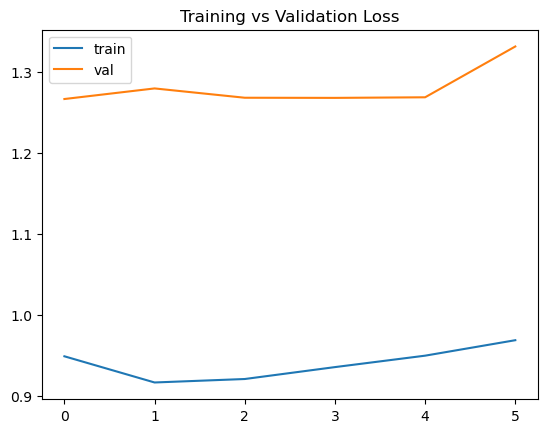

In [499]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

In [502]:
print("Mean absolute future return:", np.mean(np.abs(Y_train_scaled)))

Mean absolute future return: 0.4926620508659351


### d. Train your model on the training set

### e. Evaluate your model on the training set

### f. Evaluate your model on the test set

### g. Analyze your results

Look at your results for different horizons $h$ when predicting $diff(h)$ and compare them with the results from Section 1 using only the imbalance. Comment.

How could you improve this result?

In [506]:
sequence_length = 10  # on regarde les 10 derniers trades

def build_sequences(X, Y, seq_len):
    X_seq, Y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i, :])  # 10 derniers trades
        Y_seq.append(Y[i, :])            # target à i (ou horizon multi)
    return np.array(X_seq), np.array(Y_seq)

X_train_seq, Y_train_seq = build_sequences(X_train_scaled, Y_train_scaled, sequence_length)
X_test_seq, Y_test_seq   = build_sequences(X_test_scaled, Y_test_scaled, sequence_length)

print(X_train_seq.shape)  # (N_train_seq, 10, 5)
print(Y_train_seq.shape)  # (N_train_seq, 10)

(1263019, 10, 14)
(1263019, 1)


In [507]:
input_shape = (10, 5)  # 10 dernières trades, 4 features


input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])  # (10, 5)

model = keras.models.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=input_shape),
    layers.LSTM(32),
    layers.Dense(10)  # 10 horizons
])

In [508]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

In [509]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train_seq,
    Y_train_seq,
    validation_split=0.2,
    epochs=50,
    batch_size=5069,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.9045 - mae: 0.4382 - val_loss: 1.2386 - val_mae: 0.6511
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.8927 - mae: 0.4319 - val_loss: 1.2315 - val_mae: 0.6497
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.8874 - mae: 0.4307 - val_loss: 1.2326 - val_mae: 0.6479
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.8805 - mae: 0.4305 - val_loss: 1.2332 - val_mae: 0.6509
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.8685 - mae: 0.4300 - val_loss: 1.2369 - val_mae: 0.6496
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.8577 - mae: 0.4292 - val_loss: 1.2284 - val_mae: 0.6455
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.8448 - mae: 0.4285 - val_loss: 1.2276 - val_mae: 0.6453
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.8334 - mae: 0.4278 - val_loss: 1.2281 - val_mae: 0.6464
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms

In [510]:
test_loss, test_mae = model.evaluate(X_test_seq, Y_test_seq, verbose=1)
print("Test MSE:", test_loss)
print("Test MAE:", test_mae)

9868/9868 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - loss: 1.1242 - mae: 0.5142
Test MSE: 1.1241958141326904
Test MAE: 0.51419997215271
